In [51]:
from __future__ import print_function, division
import json
from copy import copy, deepcopy
import pandas as pd
import time
import argparse
import sys
import traceback
import matplotlib.pyplot as plt 
import numpy as np
import math
from random import random
from scipy.spatial.distance import cdist
import scipy
from itertools import combinations
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.spatial.distance import cdist
import scipy
from matplotlib import pyplot
from scipy import stats
%matplotlib inline

# 1. Closed Itemset Mining

```
Implement the CHARM algorithm for frequent closed itemset mining (see Algorithm 9.2 in chapter 9). Download the file mushroom.txt for your runs. Each line of the file contains a transaction, i.e., as set of items that occur together. The transactions do not have to be of the same length, but you may assume that each line will be sorted on the items.

Your script should accept the filename and minimum support value from the command line. It should be run as: ScriptName mushroom.txt MINSUP. Here MINSUP is in absolute numbers.

Your script should output all the frequent closed itemsets in the following format:

closed itemset - support

with one itemset and its support per line. It should also print the total number of frequent closed itemsets on the last line of the output.

Run your code on mushroom.txt for two different values of minsup, namely minsup = 5000, and minsup = 3000, and record the output.
```

In [41]:
#This is based off of brute force example and https://github.com/klepaczmikolaj/data-mining-Charm/blob/da32d5536f362b26c2f4880a1a0010d4f01dc2b1/charm.py
class DataPreparation:
    transactional = []
    tid_count = 0
    
    def import_data(self, filename):
        with open(filename, 'r') as file:
            tid = 1
            for line in file:
                line = line.strip().split()
                for element in line:
                    self.transactional.append({'tid': tid, 'item': element})
                tid += 1
        self.tid_count = tid - 1
        
    def transform_data(self):
        df = pd.DataFrame(self.transactional)
        self.itemsGrouped = df.groupby(['item'])['tid'].apply(list)
        self.itemsGrouped = pd.DataFrame({'item': self.itemsGrouped.index, 'tid': self.itemsGrouped.values})
        self.itemsGrouped['item'] = self.itemsGrouped['item'].apply(lambda x: {x})
        
    def get_frequent_items(self, min_sup):
        print('Tid count: {}'.format(self.tid_count))
        return self.itemsGrouped[self.itemsGrouped['tid'].map(len) >= min_sup]
    
class CharmAlgorithm:
    def __init__(self, min_sup_config, tid_count):
        self.result = pd.DataFrame(columns=['item', 'tid', 'support'])
        self.min_sup = min_sup_config
        
    @staticmethod
    def replace_values(df, column, find, replace):
        for row in df.itertuples():
            if find <= row[column]:
                row[column].update(replace)
                
    
    def charm_property(self, row1, row2, items, new_item, new_tid): 
        if len(new_tid) >= self.min_sup: 
            if set(row1[2]) == set(row2[2]): 
                # remove row2[1] from items 
                items = items[items['item'] != row2[1]] 
                # replace all row1[1] with new_item 
                find = copy(row1[1]) 
                self.replace_values(items, 1, find, new_item) 
                self.replace_values(self.items_tmp, 1, find, new_item) 
            elif set(row1[2]).issubset(set(row2[2])): 
                # replace all row1[1] with new_item 
                find = copy(row1[1]) 
                self.replace_values(items, 1, find, new_item) 
                self.replace_values(self.items_tmp, 1, find, new_item) 
            elif set(row2[2]).issubset(set(row1[2])): 
                # remove row2[1] from items 
                items = items[items['item'] != row2[1]] 
                # add {item, tid} to self.items_tmp 
                self.items_tmp = self.items_tmp.append({'item': new_item, 'tid': new_tid}, ignore_index=True) 
                # sort items by ascending support 
                # s = self.items_tmp.tid.str.len().sort_values().index 
                # self.items_tmp = self.items_tmp.reindex(s).reset_index(drop=True) 
            elif set(row1[2]) != set(row2[2]): 
                # add {item, tid} to self.items_tmp 
                self.items_tmp = self.items_tmp.append({'item': new_item, 'tid': new_tid}, ignore_index=True) 
                # sort items by ascending support 
                # s = self.items_tmp.tid.str.len().sort_values().index 
                # self.items_tmp = self.items_tmp.reindex(s).reset_index(drop=True) 

    
    def charm_extend(self, items_grouped): 
        # sort items by ascending support 
        s = items_grouped.tid.str.len().sort_values().index 
        items_grouped = items_grouped.reindex(s).reset_index(drop=True) 
        for row1 in items_grouped.itertuples(): 
            self.items_tmp = pd.DataFrame(columns=['item', 'tid']) 
            for row2 in items_grouped.itertuples(): 
                if row2[0] >= row1[0]: 
                    item = set() 
                    item.update(row1[1]) 
                    item.update(row2[1]) 
                    tid = list(set(row1[2]) & set(row2[2])) 
                    self.charm_property(row1, row2, items_grouped, item, tid) 
            if not self.items_tmp.empty: 
                self.charm_extend(self.items_tmp) 
            # check if item subsumed 
            is_subsumption = False 
            for row in self.result.itertuples(): 
                if row1[1].issubset(row[1]) and set(row[2]) == set(row1[2]): 
                    is_subsumption = True 
                    break 
            # append to result if element not subsumed 
            if not is_subsumption: 
                self.result = self.result.append({'item': row1[1], 'tid': row1[2], 'support': len(row1[2])}, ignore_index=True) 


    def write_result_to_file(self, result_file): 
        self.result.to_csv(result_file, sep='\t', columns=['item', 'support'], index=False) 
 
    def write_result_to_smfl_format(self, result_file): 
        self.result['item'] = self.result['item'].apply(lambda x: sorted(map(int, x))) 
        self.result.to_csv(result_file, sep='\t', columns=['item', 'support'], index=False, header=False) 

if __name__ == '__main__': 
    start = time.time()
    
    # parse args commenting these out as they don't work in jupyter but will on the command line
    #parser = argparse.ArgumentParser(description='Generate closed frequent itemsets')
    #parser.add_argument('-f', '--filename', help="Name of the file with data for itemset generation", required=True)
    #parser.add_argument('-s', '--support', help="Minimum support for frequent itemsets", required=True, type=float)
    #parser.add_argument('--output', help="Output file name, default: output.txt", required=False, default='output.txt')
    #parser.add_argument('--spmf-format', help="Specify output file format as SPMF", required=False, action='store_true')
    #args = parser.parse_args()

    # preparation 
    data = DataPreparation() 
    #data.import_data(args.filename) 
    data.import_data('mushroom.txt') 
    data.transform_data() 
    #freq = data.get_frequent_items(args.support) 
    freq = data.get_frequent_items(3000)
    freq1 = data.get_frequent_items(5000)

    # algorithm 
    #algorithm = CharmAlgorithm(args.support, data.tid_count) 
    algorithm = CharmAlgorithm(3000, data.tid_count)
    algorithm1 = CharmAlgorithm(5000, data.tid_count)
    dataframe = algorithm.result
    print(algorithm.charm_extend(freq)) 
    # write to file 
    #if args.spmf_format:
    spmf_format = False
    if spmf_format == True:
        #algorithm.write_result_to_smfl_format(args.output)
        algorithm.write_result_to_smfl_format('output.csv')
    else: 
        #algorithm.write_result_to_file(args.output)
        algorithm.write_result_to_file('output.csv')
    end = time.time() 
    print("##############################################################") 
    #print('File: ' + args.filename)
    print('File: ' + 'mushroom.txt')
    print('Python elapsed time: ' + str(round((end - start), 3)) + ' s') 

Tid count: 8124
Tid count: 8124
None
##############################################################
File: mushroom.txt
Python elapsed time: 4.64 s


# Non Derivable Itemsest

```
Your goal here is to write a program to compute whether an itemset is derivable or not. The program should take as input the following two files:

FILE1: A list of itemsets with their support values (one per line). See the file: itemsets.txt (the format is "itemset - support"; one per line)
FILE2: A list of itemsets (one per line), whose support bounds have to be derived. See the file: ndi.txt
Your program should output for each itemset in FILE2 the following info:

itemset: [l,u] derivable/non-derivable

where l and u are the lower and upper-bounds on the support.
```

In [56]:
#We went over this during our Tuesday call. Giving credit to Sam as he helped me with this
#Function to get combination for itemset and number combinations
def get_combinations(itemset, num_combinations):
    #Builds a list for combinations
    combination_list = []
    #Loops through itemset and finds combinations based on size
    for combination in combinations(itemset, num_combinations):
        combination_list.append(combination)
    return combination_list

#Function to calculate the bound value 
def calc_value(sets, itemset, dictionary, n):
    #Building our subsets based on combinations
    value = 0.0
    for num in range(n-1, 0, -1):
        #Builds list of combinations
        subsets = get_combinations(itemset, num)
        #Loops through combinations
        for combination in subsets:
            ck = all(item in combination for item in sets)
            if ck or sets == ():
                i = int(dictionary[combination]) * pow(-1.0, (n+1) - num)
                value += i #Originally I had messed this part up and put a 1 instead of i. My data showed everything as non-derivable until fixed
    if sets == (): 
        empty = 0
        for dict_value in dictionary.values():
            empty += int(dict_value)
        value += empty * pow(-1.0, (n+1))
    return value

#Function to get upper and lower bound for itemset and frequent itemset dictionary
def get_bounds(itemset, dictionary):
    upper_bounds = []
    lower_bounds = []
    lower_bound = 0
    upper_bound = 0
    n = len(itemset)
    #Loops through itemset and breaks the combinations into subsets
    for index in range(len(itemset)):
        subsets = get_combinations(itemset, index)
        #Determines if subset is odd or even
        boolean_Odd = (n - len(subsets[0]))%2
        for combination in subsets:
            #If length is odd then update upper bounds
            if boolean_Odd:
                upper_bounds.append(calc_value(combination, itemset, dictionary, n))
            #If length is even then update lower bounds
            else:
                lower_bounds.append(calc_value(combination, itemset, dictionary, n))
    #If the maximum number in lower bounds is less than zero, then we set lower bound to zero
    if max(lower_bounds) < 0:
        lower_bound = 0
    #If maximum number in lower bound is 0 or greater, than we set lower bound to that number    
    else:
        lower_bound = max(lower_bounds)
    #Setting upper bound to the minum number in upper bounds
    upper_bound = min(upper_bounds)
    #If lower and upper bounds are equal, then they are derivable
    if lower_bound == upper_bound:
        d = 'derivable'
    #If they are not equal, then set to non-derviable
    else:
        d = 'non-derivable'
    #Result gives us the findings with subset, lower and upper bound values, and answer to derivable or not
    result = '{}: [{}, {}] {}'.format(itemset, lower_bound, upper_bound, d)
    return result
#Main function for this exercise
def main():
    #Learning to put a try block in so I can include an exclusion in case
    try:
        #Getting data
        itemset_df = pd.read_csv('itemsets.txt', header = None)
        ndi_df = pd.read_csv('ndi.txt', header = None)
        #Process the data into dictionary for itemset.txt
        itemset_dict = {}
        for i, itemset_sup in enumerate(itemset_df[0]):
            set_sup_list = []
            for val in itemset_sup.split(' '):
                if val == '-':
                    continue
                else:
                    set_sup_list.append(val)
        
            itemset_dict[tuple(set_sup_list[:-1])] = set_sup_list[-1]
        #Process the data into dictionary for ndi.txt
        ndi_dict = {}
        for i, itemset in enumerate(ndi_df[0]):
            ndi_dict[i] = itemset.split(' ')
        #Prints the bounds and whether they are derivable or not    
        for itemset in ndi_dict.values():
            print(get_bounds(itemset, itemset_dict))
    #Exception block in case of error
    except Exception as exception:
        print('exception')
        # print the traceback of the exception
        traceback.print_exc()
        # list name of exception and any arguments
        print('An exception of type {0} occurred.'.format(type(exception).__name__, exception.args)); 
main()


['29', '34', '40', '52', '62']: [2888.0, 2888.0] derivable
['7', '29']: [0, 3076.0] non-derivable
['29', '48', '58']: [2997.0, 2998.0] non-derivable
['7', '29', '36', '40', '52', '58', '60']: [2890.0, 2890.0] derivable
['5', '40', '52', '60']: [2893.0, 2893.0] derivable
['7', '36', '40', '58']: [2952.0, 2952.0] derivable
['36', '40', '52', '58', '60', '66']: [2888.0, 2888.0] derivable


# High Dimensional Data Analysis

#### Hypersphere Volume: Plot the volume of a unit hypersphere as a function of dimension. Plot for d=1,⋯,50.

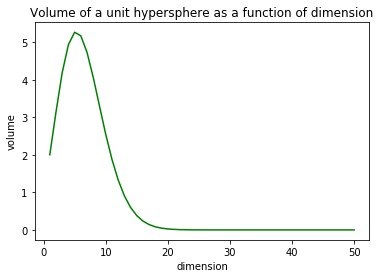

In [3]:
x = []
y = []
for dimension in range(1,51):
    d = float(dimension)
    volume = math.pi**(d/2)/math.gamma(d/2 +1)
    x.append(d)
    y.append(volume)
    
plt.plot(x,y, color='g')
plt.title('Volume of a unit hypersphere as a function of dimension')
plt.xlabel('dimension')
plt.ylabel('volume')
plt.show()

#### Hypersphere Radius: What value of radius would one need to maintain a hypersphere volume of 1 with increasing d. Plot this value for d=1,⋯,100.

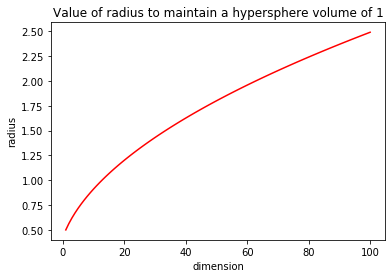

In [6]:
x = []
y = []
dimension = 1

for dimension in range(1,101):
    d = float(dimension)
    volume = math.pi**(d/2)/math.gamma(d/2 +1)
    v = float(volume)
    r = (1/v)**(1/d)
    x.append(d)
    y.append(r)
    
plt.plot(x,y, color = 'r')
plt.title('Value of radius to maintain a hypersphere volume of 1')
plt.xlabel('dimension')
plt.ylabel('radius')
plt.show()

#### Nearest Neighbors: Assume we have a unit hypercube centered at (0.5,⋯,0.5). Generate n=10000 uniformly random points in d dimensions, in the range (0,1) in each dimension. Find the ratio of the nearest and farthest point from the center of the space. Also store the actual distance of the nearest dn and farthest df points from the center. Plot these value for d=1,⋯,100.

In [32]:
#Worked with Sam on this one as well as using the resource listed below
#Comes from #1 https://mc-stan.org/users/documentation/case-studies/curse-dims-python.html
def euclidean_length(x):
    return np.linalg.norm(x)

#Function for center of hypercube
def get_center(d):
    center = []
    for val in range(d):
        center.append(.5)
    return np.array(center)

point_dict = {} #Empty dict for points
#Arrays of values for each dimension
for d in range(1,101):
    dim_points = []
    for dim in range(1, d+1):
        dim_points.append(np.random.uniform(0,1,10000))
    point_dict[d] = zip(*dim_points)
    
distances = {} #Empty dict for distances
#Looping through to get all distances for the 100 dimensions
for dimension in point_dict.keys():
    distance_list = []
    center = get_center(dimension)
    for point in point_dict[dimension]:
        distance = euclidean_length(point-center)
        distance_list.append(distance)
    distances[dimension] = distance_list
    
#Create dataframe to hold the distances dict
distance_df = pd.DataFrame(distances)


maxdist = [] #Empty list for max distances
mindist = [] #Empty list for min distances
ratios = [] #Empty list for ratios
dimensions = []

for dimension in range(1,101):
    maxdist.append(distance_df[dimension].max())
    mindist.append(distance_df[dimension].min())
    ratios.append(distance_df[dimension].min()/distance_df[dimension].max())
    dimensions.append(dimension)
    
sum_df = pd.DataFrame({'Dimensions': dimension, 'Furthest': maxdist, 'Closest': mindist, 'Ratio': ratios})
sum_df

,Dimensions,Furthest,Closest,Ratio
0,100,0.499809,0.000085,0.000170
1,100,0.702124,0.000873,0.001244
2,100,0.837244,0.027485,0.032828
3,100,0.947398,0.066909,0.070624
4,100,1.037774,0.096459,0.092948
...,...,...,...,...
95,100,3.305964,2.349560,0.710703
96,100,3.303192,2.337848,0.707754
97,100,3.326350,2.357955,0.708872
98,100,3.348905,2.371720,0.708208


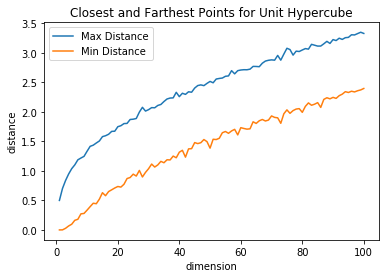

In [33]:
#Plotting the min and max distances for unit hypercube
plt.plot(dimensions, maxdist, label = 'Max Distance')
plt.plot(dimensions, mindist, label = 'Min Distance')
plt.xlabel('dimension')
plt.ylabel('distance')
plt.title('Closest and Farthest Points for Unit Hypercube')
plt.legend()
plt.show()

#### Fraction of Volume: Assume we have a hypercube of edge length l=2 centered at the origin (0,0,⋯,0). Generate n=10,000 points uniformly at random for increasing dimensionality d=1,⋯,100. Now answer the following questions:


In [17]:
#Torrey gave me https://mc-stan.org/users/documentation/case-studies/curse-dims-python.html to go off of
fraction = {}

for d in range(1,101):
    pointsl2 = np.random.uniform(-1,1,size=(10000,d))
    dist = cdist(pointsl2, np.expand_dims(np.zeros(d),0), metric = 'euclidean')
    p = np.sum(dist < 1)/10000
    fraction[d]= p

* Plot the fraction of points that lie inside the largest hypersphere that can be inscribed inside the hypercube with increasing d. After how many dimensions does the fraction go to essentially zero?

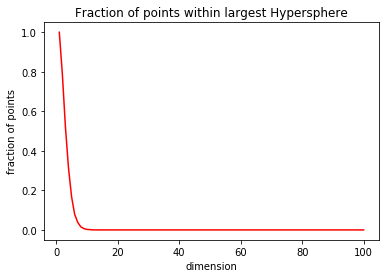

In [21]:
#Plotting
distsort = sorted(fraction.items())

x,y = zip(*distsort)

plt.plot(x,y, color = 'r')
plt.xlabel('dimension')
plt.ylabel('fraction of points')
plt.title('Fraction of points within largest Hypersphere')
plt.show()

* Plot the fraction of points in the thin shell of width ϵ=0.01 inside the hypercube (i.e., the difference between the outer hypercube and inner hypercube, or the thin shell along the boundaries). What is the trend that you see? After how many dimensions does the fraction of volume in the thin shell go to 100% (use binary search or increase the dimensionality in steps of 10 to answer this. You may use maximum dimensions of up to 2000, and you may use a threshold of 0.0001 to count the volume as essentially being 1 in the shell, i.e., a volume of 0.9999 can be taken to be equal to 1 for finding the smallest dimension at which this happens).

Dimension where Proportion >= 0.9999: 917


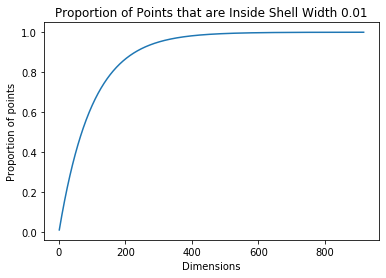

In [38]:
#Worked with Sam and used the book Data Mining and Machine Learning pgs171-172
fractions = [] #Empty list to hold fractions
dimensions = [] #Empty list to hold dimensions
for dimension in range(1,2000): #Used the max 2000
    fraction = 1-((0.99)**dimension)
    dimensions.append(dimension)
    fractions.append(fraction)
    if fraction >= 0.9999:
        print('Dimension where Proportion >= 0.9999: {}'.format(dimension))
        break
x = dimensions
y = fractions
plt.plot(x,y)
plt.xlabel('Dimensions')
plt.ylabel('Proportion of points')
plt.title('Proportion of Points that are Inside Shell Width 0.01')
plt.show()


#### Diagonals in High Dimensions

Your goal is the compute the empirical probability mass function (EPMF) for the random variable X that represents the angle (in degrees) between any two diagonals in high dimensions.

Assume that there are d primary dimensions (the standard axes in cartesian coordinates), with each of them ranging from -1 to 1. There are 2d additional half-diagonals in this space, one for each corner of the d-dimensional hypercube.

Write a script that randomly generates n=100000 pairs of half-diagonals in the d-dimensional hypercube, and computes the angle between them (in degrees).

Plot the EPMF for three different values of d, as follows d=10,100,1000. What is the min, max, value range, mean and variance of X for each value of d?

What would you have expected to have happened analytically? In other words, derive formulas for what should happen to angle between half-diagonals as d→∞. Does the EPMF conform to this trend? Explain why? or why not?

What is the expected number of occurrences of a given angle θ between two half-diagonals, as a function of d (the dimensionality) and n (the sample size)?

In [49]:
#This was in the Slack section
def compute_angle(point1, point2):
    return np.dot(point1, point2)/(np.linalg.norm(point1)*np.linalg.norm(point2))

def generate_all_angles(dimensions, pairs):
    results = np.zeros(pairs)
    for i in range(pairs):
        points = np.random.rand(2, dimensions)
        points[points<=0.5] = -1
        points[points>0.5] = 1
        results[i] = compute_angle(points[0], points[1])
    return results


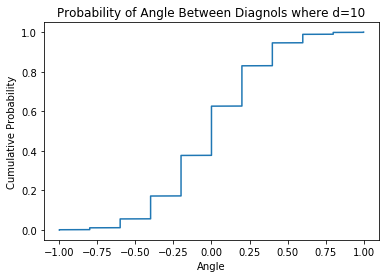

DescribeResult(nobs=100000, minmax=(-0.9999999999999998, 0.9999999999999998), mean=-0.0012659999999999998, variance=0.09947499199391992, skewness=0.0001773551848068776, kurtosis=-0.18847321429446628)


In [53]:
#Basing this off of link sent. It's ecdf instead of epmf 
array_angles = generate_all_angles(10, 100000)
ecdf10 = ECDF(array_angles)
pyplot.plot(ecdf10.x, ecdf10.y)
pyplot.xlabel('Angle')
pyplot.ylabel('Cumulative Probability')
pyplot.title('Probability of Angle Between Diagnols where d=10')
pyplot.show()
print(stats.describe(array_angles))

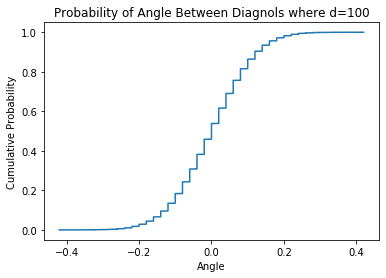

DescribeResult(nobs=100000, minmax=(-0.42, 0.42), mean=0.0002592000000000002, variance=0.00997965661192612, skewness=0.0005075146929483621, kurtosis=-0.03230950795427967)


In [55]:
#Basing this off of link sent. It's ecdf instead of epmf 
array_angles = generate_all_angles(100, 100000)
ecdf100 = ECDF(array_angles)
pyplot.plot(ecdf100.x, ecdf100.y)
pyplot.xlabel('Angle')
pyplot.ylabel('Cumulative Probability')
pyplot.title('Probability of Angle Between Diagnols where d=100')
pyplot.show()
print(stats.describe(array_angles))

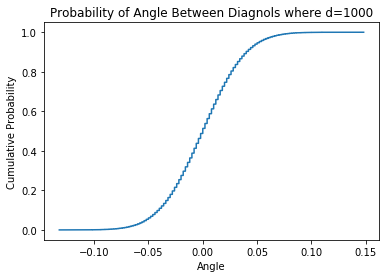

DescribeResult(nobs=100000, minmax=(-0.132, 0.148), mean=1.3979999999999988e-05, variance=0.0010022717072766727, skewness=0.01744474874008873, kurtosis=-0.0017271209221321193)


In [56]:
#Basing this off of link sent. It's ecdf instead of epmf 
array_angles = generate_all_angles(1000, 100000)
ecdf1000 = ECDF(array_angles)
pyplot.plot(ecdf1000.x, ecdf1000.y)
pyplot.xlabel('Angle')
pyplot.ylabel('Cumulative Probability')
pyplot.title('Probability of Angle Between Diagnols where d=1000')
pyplot.show()
print(stats.describe(array_angles))

# Complete the Following Exercises in Your Text

## Exercise 3.1.1 

In [26]:
list1 = ['1', '2', '3', '4']
list2 = ['2', '3', '5', '7']
list3 = ['2','4','6']

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union 

def main():
    try:
        print('List 1 against List 2: ' + str(jaccard_similarity(list1, list2)))
        print('List 1 against List 3: ' + str(jaccard_similarity(list1, list3)))
        print('List 2 against List 3: ' + str(jaccard_similarity(list2, list3)))
    except Exception as exception:
        print('exception')
        # print the traceback of the exception
        traceback.print_exc()
        # list name of exception and any arguments
        print('An exception of type {0} occurred.'.format(type(exception).__name__, exception.args));  
main()  


List 1 against List 2: 0.3333333333333333
List 1 against List 3: 0.4
List 2 against List 3: 0.16666666666666666


## Exercise 3.2.1

In [61]:
#What are the first ten 3-shingles in the first sentence of Section 3.2?
def main():
    #Creating variable for the first sentence in 3.2
    s = 'The most effective way to represent documents as sets, for the purpose of identifying lexically similar documents is to construct from the document the set of short strings that appear within it.'
    k = 3 #Amount of shingles called for in exercise
    try: 
        print(s) #Print just the sentence to start. That way output shows complete "picture"
        s_list = [s[i:i + k] for i in range(0,10)] #Creating a list that will work through each letter
        print('The first 10 3-shingles are:')
        for i in range(0, len(s_list)):
            print(str(i+1) + ': [' + s_list[i] + ']\n') #This prints out the list of 10 3-shingles by letter
        #If we want to look at words we can repeat the steps but focus on words
        w_split = s.split() #Need to split the sentence by word
        w_list = [w_split[i:i + k] for i in range(0,10)] #Creating a list that will work through each word
        print('The first 10 3-shingled words are:')
        for i in range(0, len(w_list)):
            print(str(i+1) + ': ' + str(w_list[i]) + '\n') #This prints out the list of 10 3-shingles by word
    #Exception block to catch any issues
    except Exception as exception:
        print('exception')
        # print the traceback of the exception
        traceback.print_exc()
        # list name of exception and any arguments
        print('An exception of type {0} occurred.'.format(type(exception).__name__, exception.args));  
main()
        

The most effective way to represent documents as sets, for the purpose of identifying lexically similar documents is to construct from the document the set of short strings that appear within it.
The first 10 3-shingles are:
1: [The]

2: [he ]

3: [e m]

4: [ mo]

5: [mos]

6: [ost]

7: [st ]

8: [t e]

9: [ ef]

10: [eff]

The first 10 3-shingled words are:
1: ['The', 'most', 'effective']

2: ['most', 'effective', 'way']

3: ['effective', 'way', 'to']

4: ['way', 'to', 'represent']

5: ['to', 'represent', 'documents']

6: ['represent', 'documents', 'as']

7: ['documents', 'as', 'sets,']

8: ['as', 'sets,', 'for']

9: ['sets,', 'for', 'the']

10: ['for', 'the', 'purpose']



## Exercise 3.3.3

In [21]:
#Use Fig. 3.6 matrix to solve the following:
#Worked with Teresa from other section on this
#Create variable for the element list and different sets
element = [0,1,2,3,4,5]
set1 = (0,0,1,0,0,1)
set2 = (1,1,0,0,0,0)
set3 = (0,0,0,1,1,0)
set4 = (1,0,1,0,1,0)

#Creating functions for each formula given (had help figuring out how to spell the formula out)
def h1(x):
    return ((2 * x)+1) % 6

def h2(x):
    return ((3 * x) +2) % 6

def h3(x):
    return ((5 * x) + 2) % 6

#Creating hashes based off of element list using each of the 3 hash functions
def hash_1(elem_list):
    #List to hold hash results
    hash_list = []
    #Computing hash and adding to empty list
    for i in elem_list:
        hash_list.append(((2 * i) +1) % 6)
    return hash_list

#Second hash function 
def hash_2(elem_list):
    #List to hold hash results
    hash_list = []
    #Computing hash and adding to list
    for i in elem_list:
        hash_list.append(((3 * i) +1) % 6)
    return hash_list

#Third hash function    
def hash_3(elem_list):
    #List to hold hash results
    hash_list = []
    #Computing hash and adding to list
    for i in elem_list:
        hash_list.append(((5 * i) +1) % 6)
    return hash_list
       
#Function to create a new matrix to hold the element values, sets, and hash lists
def new_matrix(hash_list_1, hash_list_2, hash_list_3):
    #Create new dataframe to hold full matrix, with column headers
    matrix = pd.DataFrame(columns=['element', 'set1', 'set2', 'set3', 'set4', 'h1', 'h2', 'h3'])
    #loop through elements, construct full matrix
    for i in range(0, len(element)):
        #Fill rows in dataframe
        matrix.loc[i] = [element[i], set1[i], set2[i], set3[i], set4[i], hash_list_1[i], hash_list_2[i], hash_list_3[i]]
    # list full matrix
    print('\nMatrix of Element, Sets, and Hashes:\n' + str(matrix))
    return matrix

#Function to help determine permutation (had help from a classmate on this one)
def compare_hash(hash_name, hash_list):
    hash_list.sort()
    element.sort()
    if hash_list == element:
        print(hash_name + 'is a true permutation of element list')
    else:
        print(hash_name + 'is not a true permutation of element list')
        
#Function to do jaccard similarity    
def jaccard_similarity(x, y):
    #Determine intersection
    intersection = len(list(set(x).intersection(y)))
    #Determine union
    union = (len(x) + len(y)) - intersection
    #Calculates and returns similarity
    return float(intersection) / union

def set_data():
    #Create new empty matrix
    matrix = []
    #Loop to go through sets and add to matrix
    for i in range(0, len(set1)):
        matrix.append([set1[i], set2[i], set3[i], set4[i]])
    print('Row Set Data: ' + str(matrix))
    return matrix

#Create signature matrix    
def minhash(data, hashfunc):
    rows = len(data)
    cols = len(data[0])
    sigrows = len(hashfunc)
    #Signature matrix
    sigmatrix = []
    #Loop to fill rows into signature matrix
    for i in range(sigrows):
        sigmatrix.append([sys.maxsize] * cols)
    #Loop to fill columns into signature matrix 
    for r in range(rows):
        hashvalue = list(map(lambda x: x(r), hashfunc))
        for c in range(cols):
            if data[r][c] == 0:
                continue
            #Looking at sigmatrix and if it's higher than hash value, it gets replaced with hash value
            for i in range (sigrows):
                if sigmatrix[i][c] > hashvalue[i]:
                    sigmatrix[i][c] = hashvalue[i]
    return sigmatrix

#Function to walk through results
def main():
    try: 
        print('Set1:' + str(set1))
        print('Set2:' + str(set2))
        print('Set3:' + str(set3))
        print('Set4:' + str(set4))
        
        hash_list_1 = hash_1(element)
        hash_list_2 = hash_2(element)
        hash_list_3 = hash_3(element)
        
        print('Hash List 1:' + str(hash_list_1))
        print('Hash List 2:' + str(hash_list_2))
        print('Hash List 3:' + str(hash_list_3))
        
        new_matrix(hash_list_1, hash_list_2, hash_list_3)
        
        print('\n(a) Compute the minhash signature for each column using three hash functions.\n')
        m_hash = minhash(set_data(), [h1, h2, h3])
        print('Minhash Data: ', str(m_hash))
        
        print('\n(b) Which of these hash functions are true permutations?\n')
        compare_hash('Hash 1 ', hash_list_1)
        compare_hash('Hash 2 ', hash_list_2)
        compare_hash('Hash 3 ', hash_list_3)
        
        print('\n(c) How close are the estimated Jaccard similirities for the six pairs of columns to the true Jaccard similarities?\n')
        print('S1 and S2 = ' + str(jaccard_similarity(set1, set2)))
        print('S1 and S3 = ' + str(jaccard_similarity(set1, set3)))
        print('S1 and S4 = ' + str(jaccard_similarity(set1, set4)))
        print('S2 and S3 = ' + str(jaccard_similarity(set2, set3)))
        print('S2 and S4 = ' + str(jaccard_similarity(set2, set4)))
        print('S3 and S4 = ' + str(jaccard_similarity(set3, set4)))
    #Exception block in case I hit any errors    
    except Exception as exception:
        print('exception')
        # print the traceback of the exception
        traceback.print_exc()
        # list name of exception and any arguments
        print('An exception of type {0} occurred.  Arguments:\n{1!r}'.format(type(exception).__name__, exception.args));   
        
    
main()


Set1:(0, 0, 1, 0, 0, 1)
Set2:(1, 1, 0, 0, 0, 0)
Set3:(0, 0, 0, 1, 1, 0)
Set4:(1, 0, 1, 0, 1, 0)
Hash List 1:[1, 3, 5, 1, 3, 5]
Hash List 2:[1, 4, 1, 4, 1, 4]
Hash List 3:[1, 0, 5, 4, 3, 2]

Matrix of Element, Sets, and Hashes:
  element set1 set2 set3 set4 h1 h2 h3
0       0    0    1    0    1  1  1  1
1       1    0    1    0    0  3  4  0
2       2    1    0    0    1  5  1  5
3       3    0    0    1    0  1  4  4
4       4    0    0    1    1  3  1  3
5       5    1    0    0    0  5  4  2

(a) Compute the minhash signature for each column using three hash functions.

Row Set Data: [[0, 1, 0, 1], [0, 1, 0, 0], [1, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1], [1, 0, 0, 0]]
Minhash Data:  [[5, 1, 1, 1], [2, 2, 2, 2], [0, 1, 4, 0]]

(b) Which of these hash functions are true permutations?

Hash 1 is not a true permutation of element list
Hash 2 is not a true permutation of element list
Hash 3 is a true permutation of element list

(c) How close are the estimated Jaccard similirities for the

## Exercise 3.4.1

R = 3, B = 10


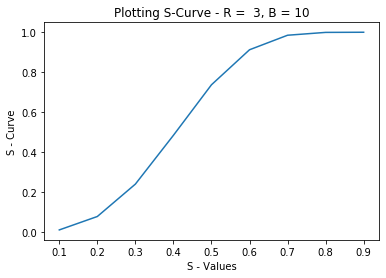

R = 6, B = 20


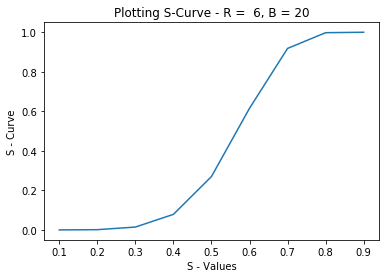

R = 5, B = 50


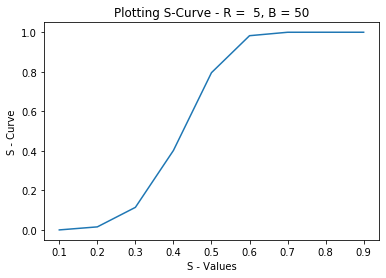

In [48]:
#Evaluate the S-curve .... for the following values of r and b:

#Going to create variables from the r and b values
r1 = 3
b1 = 10
r2 = 6
b2 = 20
r3 = 5
b3 = 50

#creating a list for s
s_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def compute_s_curve(row, band):
    print('R = {}, B = {}'.format(row, band))
    s_curve = []
    for i in range(0, len(s_values)):
        s_curve.append(1-(1-s_values[i]**row)**band)
    return s_curve
    
def plot_s_curve(s_curve_list, row_name, band_name):
    # x axis values 
    x = s_values 
    # y axis values
    y = s_curve_list
    
    # plotting the points
    plt.plot(x,y)
    
    #axis titles
    plt.xlabel('S - Values') 
    plt.ylabel('S - Curve')
    plt.title('Plotting S-Curve - R =  ' + row_name + ', B = ' + band_name) 
    # show the plot 
    plt.show() 
    
# main function to obtain list of first 10 3-shingles in the sentence
def main():
    # try block for execution
    try:
        # call to compute and plot s-curve for all three sets of rows and bands
        plot_s_curve(compute_s_curve(r1, b1), str(r1), str(b1))
        plot_s_curve(compute_s_curve(r2, b2), str(r2), str(b2))
        plot_s_curve(compute_s_curve(r3, b3), str(r3), str(b3))
    # exception block to catch any exceptions during execution
    except Exception as exception:
        print('exception')
        # print the traceback of the exception
        traceback.print_exc()
        # list name of exception and any arguments
        print('An exception of type {0} occurred.'.format(type(exception).__name__, exception.args));    


main()